# Projet 06 : Améliorez le produit IA de votre start-up

***
# I) Rappel de l'étude de faisabilité

**Contexte** : Notre société "Avis Restau" dispose d’une plateforme de relation clients/retaurants. Nous allons ajouter la fonctionnalité permettant à l’utilisateur de poster des avis et des photos.  
**Objectif** : Nous souhaitons exploiter cette nouvelle fonctionnalité pour connaître les thèmes d’insatisfaction des clients en pouvant : 
 - extraire les données via une API
 - détecter les sujets d’insatisfaction dans les avis
 - labelliser automatiquement les photos avec la bonne catégorie

**Projet** : Mener une étude faisabilité pour décidier si oui ou non, nous nous lançons dans un plus gros projet.

***
# II) Démarche méthodologique

Ma démarche s’articule autour de 4 phases : 
 - la collecte des données : les reviews de restaurant avec des notes faibles et les photos associées
 - les traitements de preprocessing : transformer et nettoyer le texte et les images
 - l'utilisation d'algorithme de détection et prédiction : détecter les sujets d'insatisfaction et labelliser automatiquement les photos
 - évaluer les résultats par comparaison : pour discuter sur la pertinence des choix précédents et valider ou non le résultat

***
# III) Volet I : Collecte des données via l'API

Pour la collecte des données par API, j’ai testé 2 méthodes : Yelp Fusion et GraphQL.  
Yelp Fusion présentait des limitations comme l’impossibilité de récupérer toutes les reviews.  
J’ai donc porté mon choix sur GrapQL car cela me permettait de satisfaire les obligations du cahier des charges telles que : 
 - définir une taille d’échantillon de 200 restaurants en prenant en compte la limitation technique de 50 lignes par paquets
 - mettre en place des filtres, par exemple que ce soit des restaurants aux USA
 - récupérer uniquement les champs nécessaires comme le nom du restaurant, ses reviews avec le rating et le texte associé
 - et enfin stocker ces données dans un fichier csv

Une problématique réside dans le fait que notre dataset présente plusieurs millions de lignes. J’ai utilisé Dask qui permet de manipuler des dataset très volumineux. Cela m’a permis notamment de récupérer les reviews de restaurants ayant un rating de 1 ou 2.
Nous avons alors un dataset d’étude de 3404 restaurants, soit 3887 reviews, caractérisés par 4 colonnes : 
 - l’identifiant unique du restaurant
 - le nom du restaurant
 - le rating de la review
 - le texte de la review

***
# IV) Volet II : Détection des sujets d'insatisfaction dans les commentaires

## Preprocessing

Tout d'abord, nous devons effectuer des traitements de preprocessing sur les données texte pour pouvoir les utiliser dans nos algorithmes.  
Nous avons enchaîné plusieurs transformations : 
 - la normalisation pour passer tous les mots minuscules
 - la tokenization pour obtenir des listes de mots
 - la suppression des stopwords pour garder l’essentiel du sens des phrases
 - la lemmatisation pour obtenir la forme canonique des mots

Ensuite, nous avons effectué un traitement de différents filtres : 
 - en nous appuyant sur les tags POS, nous avons supprimé les adjectifs, les adverbes, les nombres, etc.
 - au vu de la liste de mots, j’ai également supprimé des mots que je ne trouvais pas pertinents comme restaurant, like, go, etc.
 - enfin, j’ai supprimé les mots trop présents ou pas assez. En effet, s’ils sont rares ou s’ils sont présents partout, ils ne nous permettront pas de distinguer des thèmes

<font size="4">**Nuage de mots avec l'ensemble des commentaires négatifs**</font>
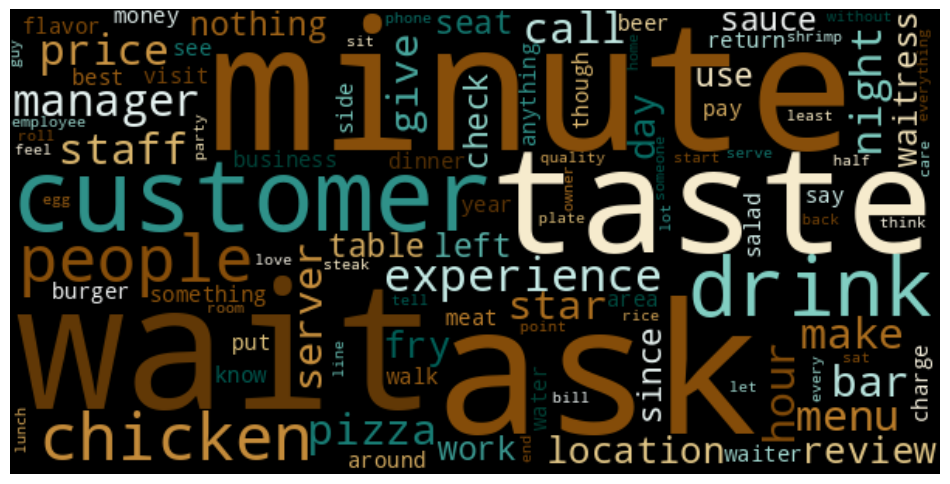

Nous pouvons voir que différents mots ressortent plus tels que time, minute, ask, wait, customer, taste, experience… Cela nous renseigne sur des thèmes comme la relation client et le temps qui seront probablement mis en évidence dans la suite de notre étude.

## Conversion mots en nombres

Cependant, nos algorithmes ne peuvent traiter des mots. Ils leur faut des nombres. C’est pourquoi, nous allons maintenant traduire ces mots en vecteur.
Nous avons utilisé 2 méthodes :
 - le Bag of Words avec Tf-Idf : on effectue un comptage des occurrences de chaque mot. Mais on perd le sens et l’ordre des mots
 - le Word Embedding avec Word2vec : permet une réduction de dimension et considère le mot dans son contexte.

<font size="4">**Représentation t-SNE du traitement Word Embedding**</font>
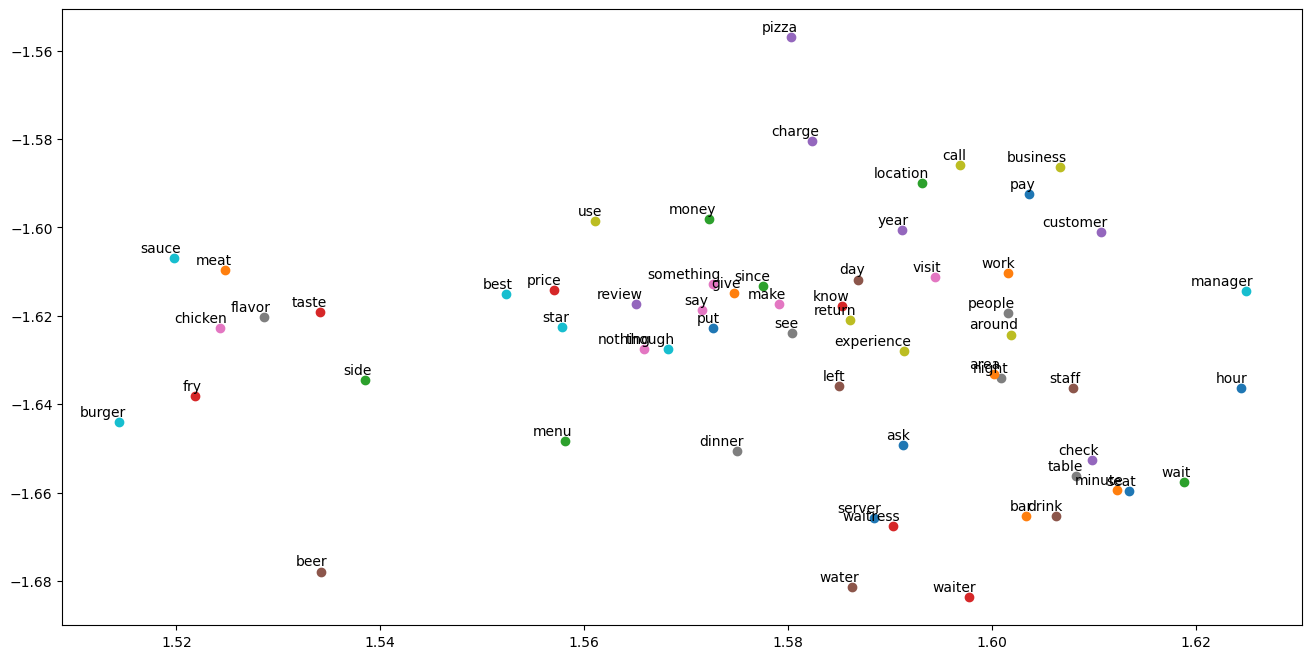

On peut voir que certains mots ayant un sens proche sont regroupés dans la même zone : 
 - flavor, taste and sauce à gauche
 - server, waitress and waiter un bas
 - wait, minute and hour à droite
 - best, price, star and review au milieu

Cela nous donne également une bonne idée des thèmes que nous allons établir dans la suite de notre étude. Cependant, pour les modèles que nous allons utiliser, nous opterons pour la première méthode avec Tf-Idf.

## Détection des thèmes

Pour détecter les thèmes principaux dans nos reviews, nous avons testé 2 algorithmes : 
 - Latent Dirichlet Allocation (LDA) ayant une approche probabiliste. Les mots sont initialement assignés de manière aléatoire aux thèmes. A chaque itération, les mots sont réassignés en ajustant leurs probabilités en fonction des distributions des thèmes et des mots. Le but est de tendre vers une meilleure cohérence.
 - Negative Matrix Factorisation (NMF) ayant une approche non probabiliste. Calcule 2 matrices, l’une représente l’importance de chaque thème dans chaque review, l’autre représente la contribution de chaque mot à chaque thème.

Ce dernier est très efficace quand une review parle majoritairement d’un seul topic. Mais nos reviews peuvent parler de plusieurs sujets en même temps puisque le client peut vraisemblablement parler de tout ce qu'il a sur le coeur. Nous allons donc plutôt utiliser l’algorithme LDA.

Le LDA choisi est celui du framework Gensim. Par le biais d’un GridSearch, j’ai optimisé le modèle en jouant sur les paramètres du nombre de topics (entre 5 et 7) et le nombre de passes, càd le nb de fois que l’on fait tourner le modèle (entre 20 et 40).  
Et enfin, j’ai validé le choix en m’appuyant sur le score de cohérence de Gensim. Ce score mesure à quel point, les mots les plus importants d'un thème sont liés sémantiquement les uns aux autres (similarités entre les mots). Il permet d'évaluer la pertinence des thèmes identifiés.  
Le meilleur score de 0.496 a été obtenu avec 7 topics pour 20 passes.

<font size="4">**Regroupement des mots par topic selon LDA Gensim**</font>
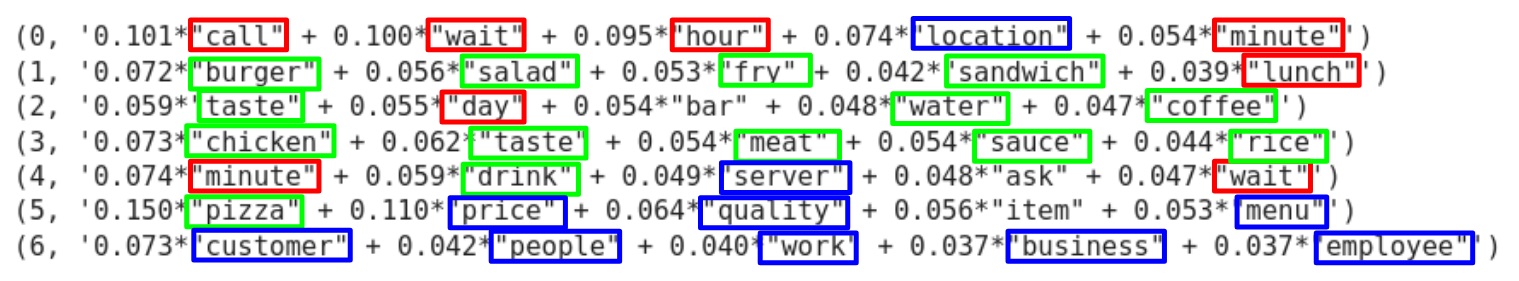

J’ai repéré que certains topics peuvent être regroupés en 3 thèmes : 
 - <span style='color:blue'> **temps et réservation** </span>
 - <span style='color:green'> **alimentation, nourriture et boissons** </span>
 - <span style='color:red'> **gestion du restaurant et relation client** </span>

<font size="4">**Représentation pyLDAvis des mots par topic selon LDA Gensim**</font>
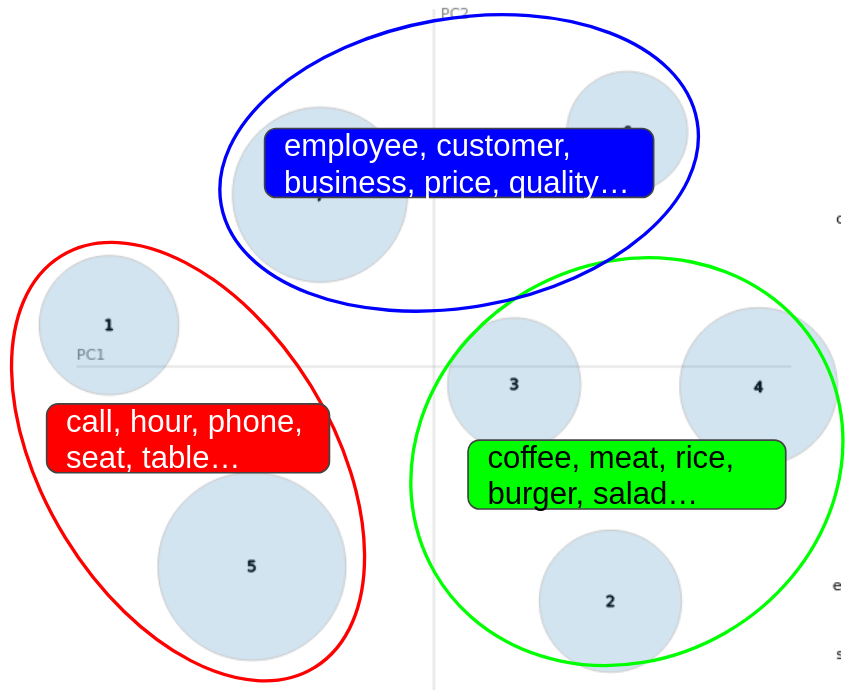

Sur cette représentation avec le framework pyLDAvis, nous voyons à nouveau comment les 3 thèmes principaux se distinguent bien : 
 - <span style='color:blue'> **le temps et la réservation** </span> sont situés sur la gauche avec des mots comme call, hour, phone, seat et table
 - <span style='color:green'> **la nourriture et les boissons** </span> sont situés en bas à droite avec des mots tels que coffee, meat, rice, burger et salad
 - <span style='color:red'> **la gestion du restaurant et la relation client** </span> est en haut avec les mots employee, customer, business, price et quality

***
# V) Volet III : Labellisation automatique des photos postées

La labellisation automatique des photos postés par les clients nécessite un traitement spécifique également. Voici les différentes étapes : 
 - la collecte des données en récupérant un échantillon
 - le preprocessing pour traiter les couleurs, le bruit et le contrast de images
 - l’extraction des descripteurs, càd les points remarquables de chaque image comme les contours, les coins…
 - la création de features par image via l’utilisation d’outils comme le clustering et la réduction de dimension
 - la représentation graphique simplifiée en 2 dimensions via t-SNE
 - l’évaluation des résultats en comparant avec le ARI-Score

Comme évoqué dans le cahier des charges, nous avons récupéré un échantillon de 200 photos par catégorie. A savoir qu’il y a 5 catégories **food, inside, outside, drink et menu**.  
Ce qui nous donne donc un total de 1000 photos.

Affichons quelques photos aléatoires de chaque catégorie.

<font size="4">**FOOD**</font>  
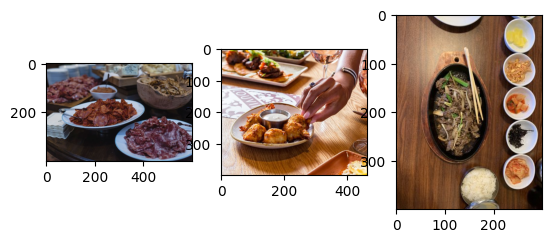

<font size="4">**INSIDE**</font>  
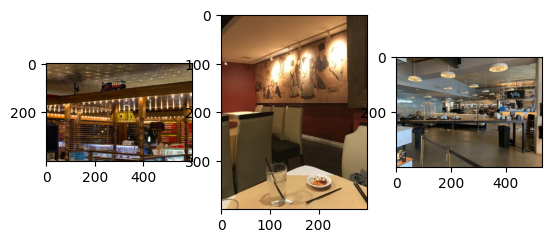

<font size="4">**DRINK**</font>  
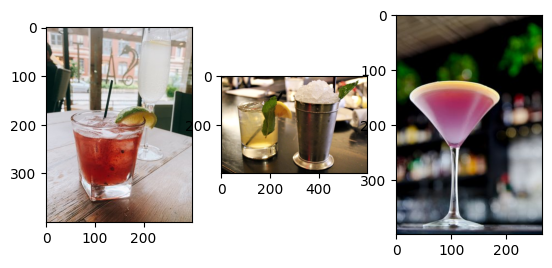

<font size="4">**OUTSIDE**</font>  
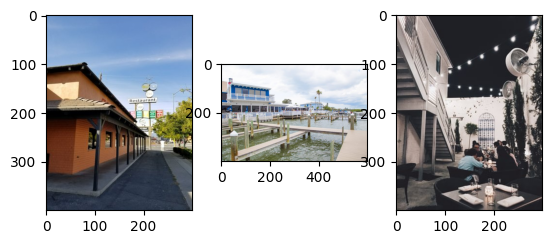

<font size="4">**MENU**</font>  
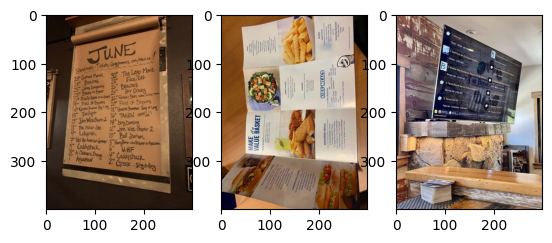

## Traitements de preprocessing pour les données images

Voici les différentes étapes de preprocessing pour l'analyse d'images : 
 - le chargement de l'image brute
 - la conversion en noir et blanc pour avoir un seul canal de niveau de gris au lieu de 3 canaux de couleur RGB (réduction de dimension)
 - le filtrage du bruit pour obtenir des images non dégradées
 - l'égalisation de l'histogramme de l'image pour permettre d'améliorer le contraste de l'image
 - l'extraction des descripteurs de l'image qui sont les points remarquables, ie, contours et coins

<font size="4"><center>Image brute</center></font>||<font size="4"><center>Image convertie en noir et blanc</center></font>
:-|:-|:-
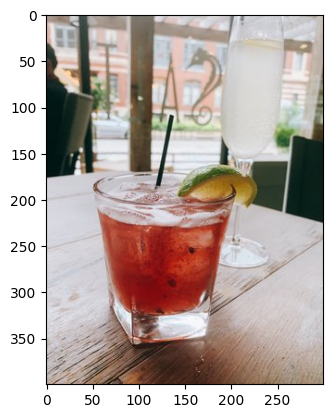|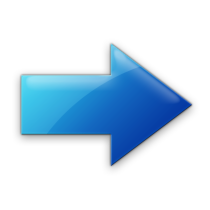|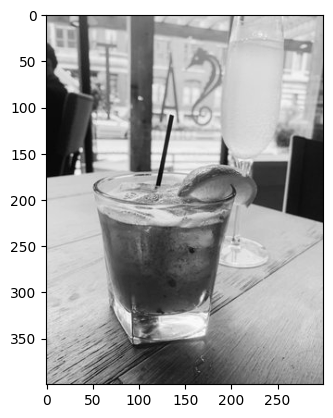

<font size="4"><center>Image convertie en noir et blanc</center></font>||<font size="4"><center>Image sans bruit</center></font>
:-|:-|:-
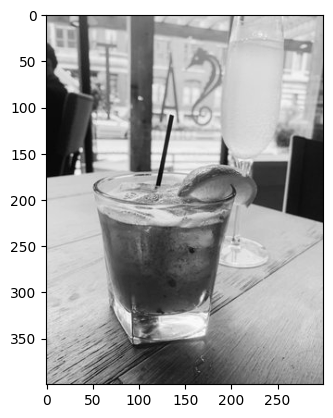|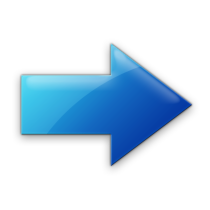|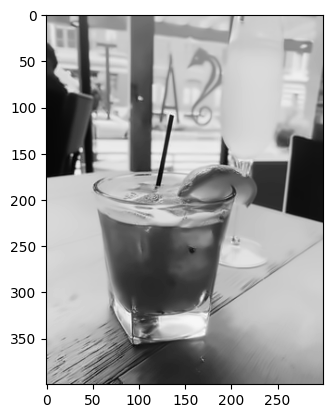

<font size="4"><center>Image sans bruit</center></font>||<font size="4"><center>Image histogramme égalisé</center></font>
:-|:-|:-
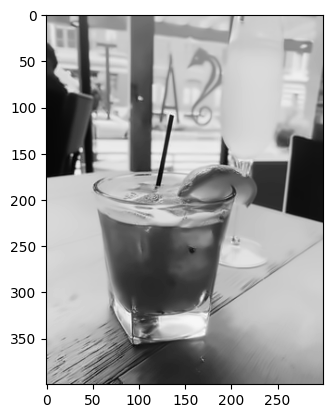|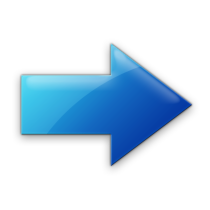|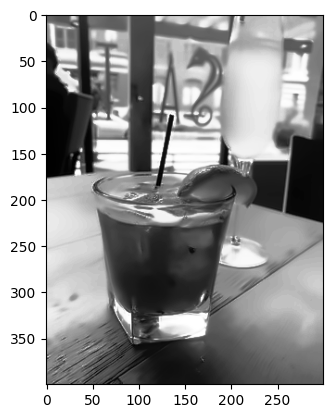

<font size="4"><center>Image histogramme égalisé</center></font>||<font size="4"><center>Image avec descripteurs</center></font>
:-|:-|:-
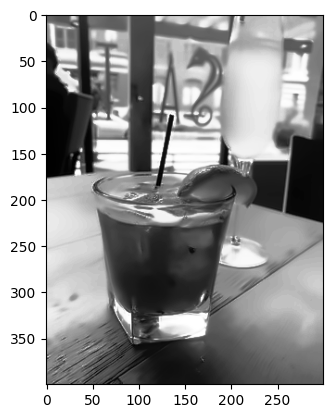|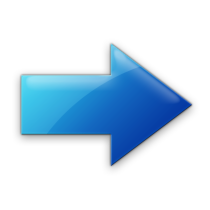|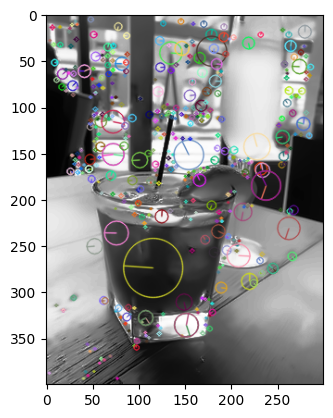

Pour la détection des descripteurs, j'ai testé 2 algorithmes SIFT et ORB. Cependant, j’ai eu de meilleurs résultats avec SIFT. Donc, à partir de maintenant, je vais uniquement parler de ce que j’ai obtenu grâce à SIFT.  
On obtient alors une liste de **450 168** descripteurs pour l'ensemble des photos de l'échantillon.

## Analyse non supervisée avec SIFT

On va maintenant regrouper ces descripteurs. Pour cela, on commence par définir un nombre de clusters cible. J’ai choisi la méthode consistant à prendre la racine carrée du nombre de descripteurs car elle m’a donné de meilleurs résultats.  
J’ai ensuite utilisé l’algorithme du MiniBatchKMeans car plus rapide que le KMeans classique pour obtenir **671 clusters**.

<font size="4"><center>Image avec descripteurs</center></font>||<font size="4"><center>Clustering des descripteurs</center></font>
:-|:-|:-
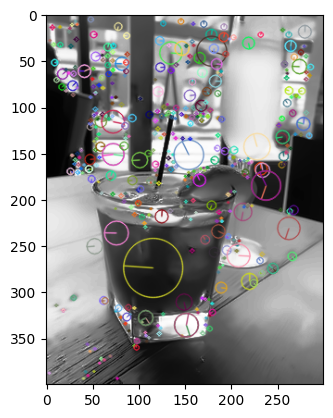|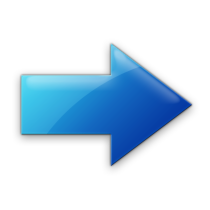|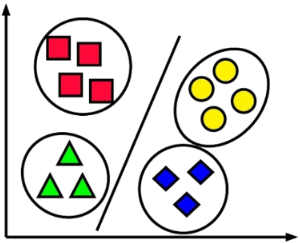

On effectue ensuite, par image, un comptage des descripteurs par cluster. Cela nous donne un histogramme représentatif de l’image. Chaque colonne représente un cluster. Le décompte obtenu est une des **671 features** de l’image. On procède ainsi pour chacune des images.  
Le nombre de features est trop important pour une représentation graphique mais aussi pour le temps de traitement pour la suite.

<font size="4"><center>Clustering des descripteurs</center></font>||<font size="4"><center>Histogrammes des images</center></font>
:-|:-|:-
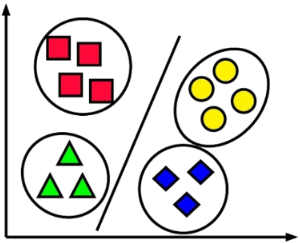|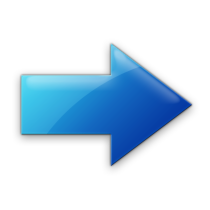|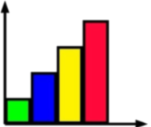

Nous allons donc effectuer une première réduction de dimensions à l’aide d’un PCA. On choisit de conserver les composantes expliquant 99% des données.  
On passe alors de 671 à **532 features**.  
Enfin, pour représenter graphiquement nos images en 2 dimensions, nous allons utiliser la méthode t-SNE. Elle permet de passer d’un dataset présentant énormément de features à un dataset présentant très peu de features. Cette transformation va préserver le clustering original.  
On passe alors de 532 à **2 features**.

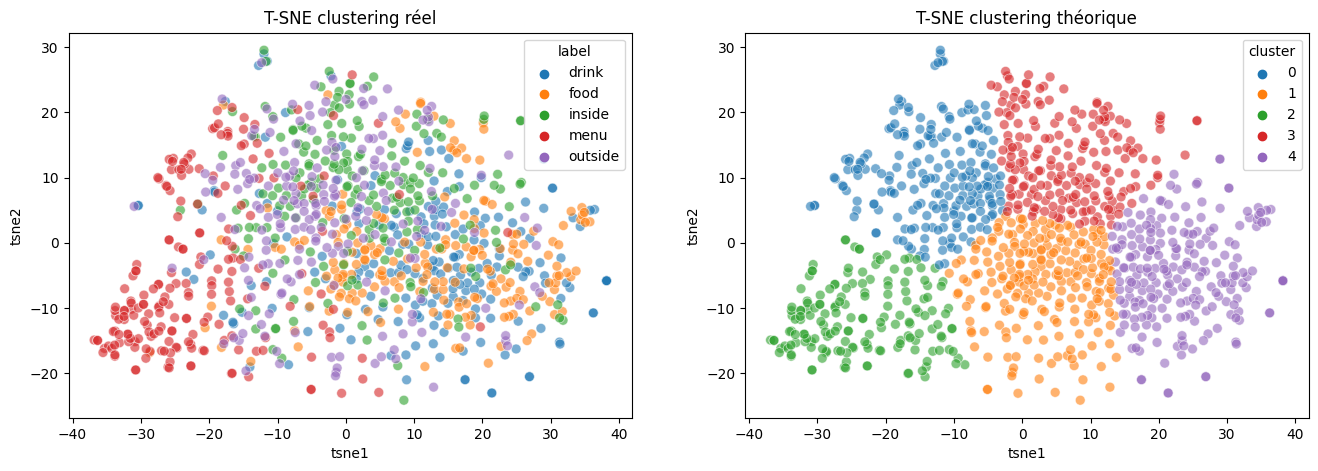

A gauche, nous avons la représentation réelle de nos données avec leur label original. A droite, nous avons le clustering théorique vers lequel nous voulons tendre.  
On voit que sont globalement mélangées comme peut l'attester le **ARI-Score de 0.157**. Mais on arrive à distinguer certains clusters : 
 - <span style='color:red'> **menu** </span> sont dans une partie distincte en bas à gauche
 - <span style='color:orange'> **food** </span> et <span style='color:blue'> **drink** </span> sont plus dans la partie droite car faisant référence à une nature similaire
 - <span style='color:green'> **inside** </span> et <span style='color:purple'> **outside** </span> sont plus dans la partie en haut car également faisant référence à une nature similaire

<font size="4">**Matrice de confusion selon la prédiction SIFT**</font>  
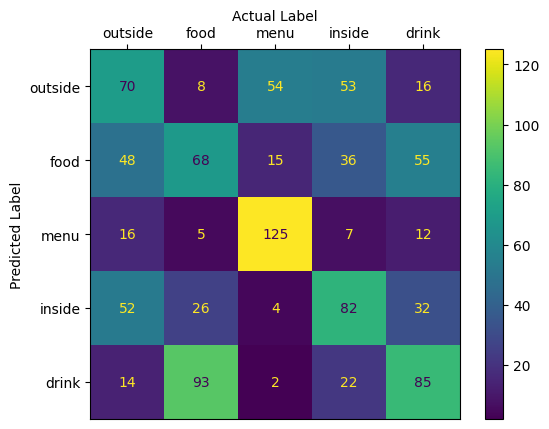

Une autre approche pour mesurer l’exactitude de la détection est de le représenter sous la forme d’une matrice de confusion. Cependant, quid de la correspondance. En effet, on ne peut pas être sûr qu’un label correspond bien au cluster théorique surtout avec un ARI-score si bas. J’ai choisi cette représentation théorique qui maximise le **score d’accuracy à 0.43**.  
Nous sommes donc limités par cette approche par SIFT. Nous allons donc utiliser une autre approche, le Transfer Learning.

## Analyse non supervisée avec Transfer Learning

Le principe est simple, utiliser un modèle préalablement entraîné. J’ai choisi le modèle VGG16 qui a été entraîné sur 14 millions d’images de 1000 catégories différentes. Il s’agit d’un réseau de neurones très fréquemment utilisé en reconnaissance d’image.  
Ensuite, on supprime la dernière couche qui traduit les données de sortie en classification de l’image. Le modèle restant permet d’obtenir directement les features de nos images.  
On obtient alors **25 088 features**.

Partant de ces 25 088 features, nous faisons comme précédemment, càd, une réduction de dimension par PCA, puis une représentation par t-SNE. J’ai testé en faisant une réduction PCA qui me donne alors **919 features**. Puis j’ai testé sans faire de réduction par PCA et donc en gardant les **25 088 features**.  
J’ai alors évaluer les résultats en les comparant.

||VGG16 w PCA|VGG16 wo PCA|SIFT|
|--|--|--|--|
|ARI-Score|0.390|0.418|0.157|
|Accuracy|0.592|0.685|0.430|

On peut voir une nette amélioration du ARI-Score grâce au VGG16, et encore plus sans la réduction PCA avec **0.418**.  
Par ailleurs, l'accuracy monte à **0.685**.

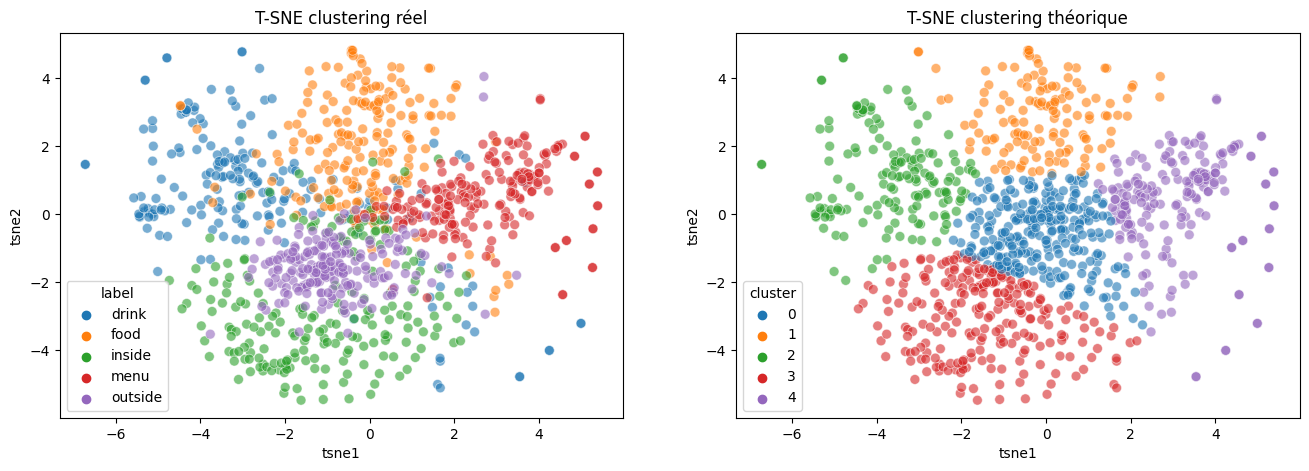

On observe bien des clusters plus distincts. On a même le cluster central. On peut remarquer les mêms particularité de zone qu'avec SIFT : 
 - <span style='color:red'> **menu** </span> sont dans une partie distincte en haut à droite
 - <span style='color:orange'> **food** </span> et <span style='color:blue'> **drink** </span> sont plus dans la partie en haut à gauche avec un mélange à la jonction
 - <span style='color:green'> **inside** </span> et <span style='color:purple'> **outside** </span> sont plus dans la partie en bas avec un cluster enclavé dans l'autre. Cela montre une plus similarité entre ces 2 catégories. Ce qui semble logique étant donné que ce sont des éléments de décors.

<font size="4">**Matrice de confusion selon la prédiction Transfer Learning**</font>  
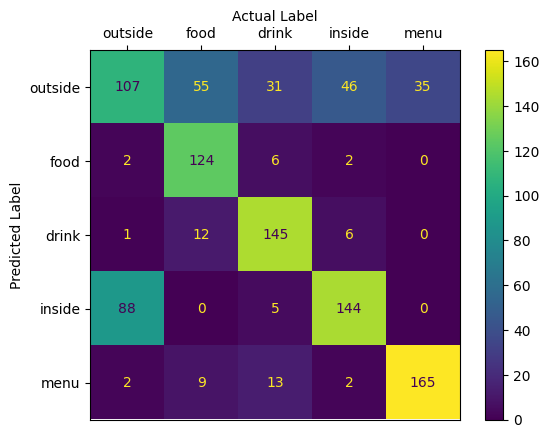

La matrice de confusion nous donne une accuracy plus élevée signe que les prédictions sont de bonnes qualités. On retrouve à nouveau la similarité entre inside et outside. La meilleure détection est toujours le menu. En revanche, les photos outside semblent plus complexes à prédire. En effet, si on regarde l'une des photos aléatoires plus haut, nous voyons également des clients et des tables. Cela pourrait très bien être confondu avec inside ou même food si un repas a été servi.

***
# VI) Synthèse des résultats

Commençons par rappeler les objectifs : 
 - la collecte des données en utilisant une API, en choisissant un échantillon et des filtres
 - l’analyse des commentaires client en détectant les thèmes négatifs récurrents
 - l’analyse des photos postées en labellisant automatiquement par catégorie

Nous avons respecté le cahier des charges pour chaque volet de notre étude.

1) Collecte des données : 
 - Echantillon de données de 200 restaurants et leurs reviews
 - Récupérer uniquement les champs nécessaires
 - Stocker les résultats dans un fichier exploitable (csv)

2) Analyse des commentaires client : 
 - Sélection de quelques milliers de commentaires négatifs
 - Prétraitement des données textuelles et Utilisation de techniques de réduction de dimension
 - Visualisation des données de grandes dimensions afin de détecter des mots clés et sujets d’insatisfaction

3) Analyse des photos postées : 
 - Sélection de 100 à 200 photos par catégorie
 - Prétraitement des images et Utilisation de techniques de réduction de dimension
 - Visualisation des données de grandes dimensions en mettant en évidence les catégories des images
 - Vérification que les images sont correctement regroupées selon les catégories

Et pour résumer, nous pouvons citer tous les outils et techniques que nous utiliserons : 
 - Collecte des données : API GraphQL
 - Détection sujets insatisfaction client : LDA avec la représentation pyLDAvis
 - Labellisation automatique par catégorie : le modèle de Transfer Learning VGG16 sans réduction PCA

***
# VII) Conclusions

Notre étude préliminaire est un succès.  
Même si j’aurai pu améliorer les résultats, notamment : 
 - avec une machine plus puissante, faire l’analyse non supervisée sur toutes les données
 - avec plus de temps, tester d’autres modèles que ce soit NLP ou Transfer learning, entraîner les modèles de TF sur nos données ou encore ajouter des couches dans ces modèles

Mais on voit déjà la nette amélioration sans cela. C’est donc prometteur pour que, selon moi, nous développions un modèle spécifique à notre besoin entraîné avec nos données.  
Et la perspective est simple : réaliser le projet final.